# Get the Data:

## Create the Data loading Function:

In [188]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/refs/heads/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [189]:
housing = load_housing_data()

In [190]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [191]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [192]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

# Create a Test Set:

## Method 1:
Using Numpy and Simple Maths:

In [193]:
import numpy as np
import pandas as pd

In [194]:
def shuffle_and_split(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)

    test_set_indices = shuffled_indices[:test_set_size]
    train_set_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_set_indices],data.iloc[test_set_indices]

In [195]:
shuffled_train_set,shuffled_test_set = shuffle_and_split(housing,0.2)

In [196]:
len(shuffled_train_set),len(shuffled_test_set)

(16512, 4128)

## Method 2:
Using hash value for the data splittig, to understand wheather or not it should go in the test set:

In [197]:
from zlib import crc32
def is_id_in_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier))< test_ratio * 2 ** 32

def split_data_with_id_hash(data,test_ratio,id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]

Since, housing data does not have index lets create one:

In [198]:
housing_with_ids = housing.reset_index() # adds an index column
housing_with_ids["id"] = housing["longitude"] * 1000 + housing["latitude"]

In [199]:
index_train_set,index_test_set  = split_data_with_id_hash(housing_with_ids,0.2,"index")

In [200]:
len(index_train_set),len(index_test_set)

(16512, 4128)

We can also make a seprate ID column with the combination for some pre-exisiting information. (Which might not change in Years)

In [201]:
housing_with_ids["id"] = housing["longitude"] * 1000 + housing["latitude"]

In [202]:
id_train_set,id_test_set  = split_data_with_id_hash(housing_with_ids,0.2,"id")

In [203]:
len(id_train_set),len(id_test_set)

(16322, 4318)

## Method 3
Using Skicit Learn's train_test_split()
Works same as shuffle_split() but have additional features.
1. random_state
2. Can split multiple datasets into subset. (Useful when we want seprate dataframes for our labels)

In [204]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [205]:
len(train_set),len(test_set)

(16512, 4128)

# Feature Engineering (Stratified Sampling Bias):

Create a Income Category Attribute to prevent sampling bias and ensure your training and test sets are representative of the entire dataset.

In [206]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [207]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0,1.5,3.0,4.5,6,np.inf],labels=[1,2,3,4,5])

In [208]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


Represent the Income Category in the form of Bar Graph:

In [209]:
import matplotlib.pyplot as plt

In [210]:
housing.income_cat.value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

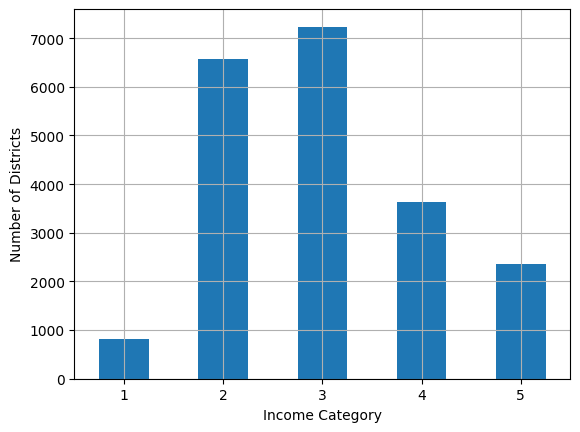

In [211]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

# Stratified Split of the same data(Income Category):

### Pre-Defining the Splitter:

In [212]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

In [213]:
strat_splits = []

for train_index,test_index in splitter.split(housing,housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])

In [214]:
strat_train_set,strat_test_set = strat_splits[0]

## train_test_split used for same thing:

In [215]:
strat_train_set,strat_test_set = train_test_split(housing,test_size=0.2,stratify=housing["income_cat"],random_state=42)

# Observe the Proportion of Income category in the test set:

In [216]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

After observing the proportion, we conclude that we'll not use the "income_cat" column again, do drop it from both the test set and training set.

In [217]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [218]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

In [219]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

# Visualizing the Data to Gain Insights:

We're gonna have some manipulation on the training data, So let's make a copy of it:

In [220]:
housing_copy = strat_train_set.copy()

## Visualizing Geographical Data:

In [221]:
housing_copy.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

<Axes: xlabel='longitude', ylabel='latitude'>

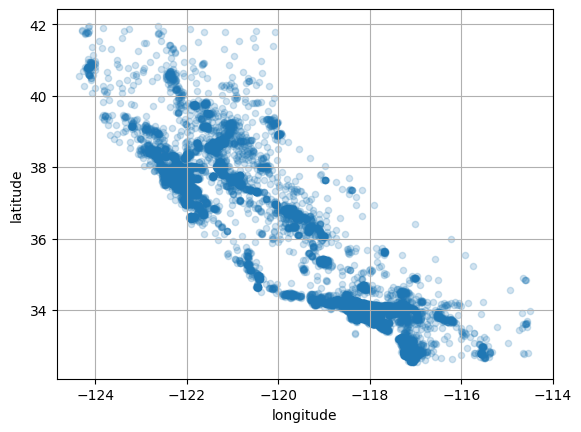

In [222]:
housing_copy.plot(kind="scatter",x="longitude",y="latitude",grid=True,alpha=0.2)

## Representing it in good format:
1. Radius of Circle represents each district's population. (option s) then use label.
2. The color of circles represents price. (option c)
3. Using a pre-defined colormap called jet, ranges from blue (low values) to red (high values). (option cmap)

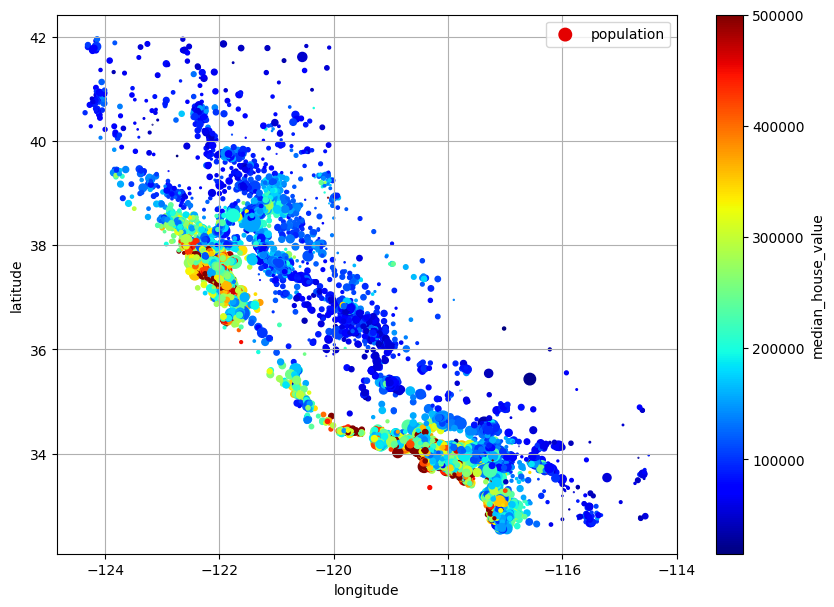

In [223]:
housing_copy.plot(kind="scatter",x="longitude",y="latitude",grid=True,s=housing_copy["population"]/100,label='population',c='median_house_value',cmap="jet",colorbar=True,legend=True,sharex=False,figsize=(10,7))
plt.show()

# Look for Correlations:

Compute Standard Correlation Coefficient:

In [224]:
corr_matrix = housing_copy.drop("ocean_proximity",axis=1).corr()

In [225]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

## Scatter Matrix Function:

In [226]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]

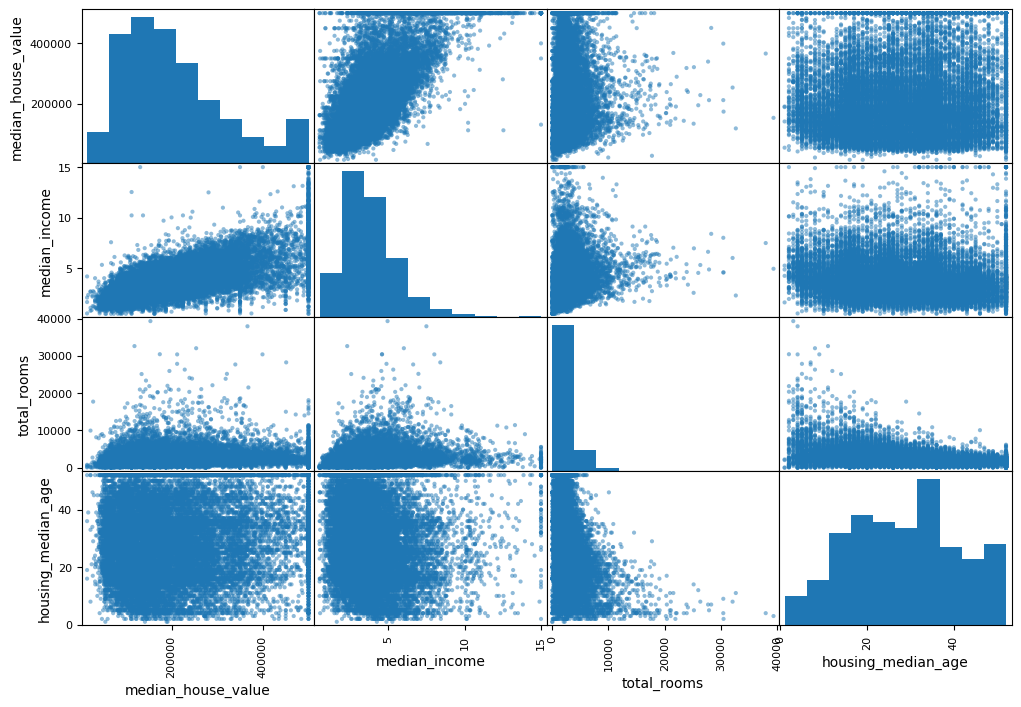

In [227]:
scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()

## We got the most promising correlated attribute for median_house_value i.e median_income:
Let's take a closer look:

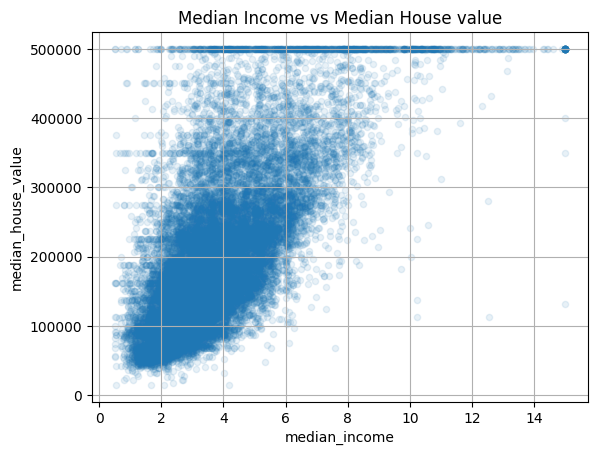

In [228]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",grid=True,alpha=0.1)
plt.title("Median Income vs Median House value")
plt.show()

# Feature Engineering (Attribute Combinations):

In [229]:
housing_copy.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

## We need the first combination to be the rooms per houses:

In [230]:
housing_copy["rooms_per_house"] = housing_copy["total_rooms"] / housing_copy["households"]

## The second we need is bedrooms per room ratio:

In [231]:
housing_copy["bedroom_ratio"] = housing_copy["total_bedrooms"] / housing_copy["total_rooms"]

## The third will be No. of people living in a house:

In [232]:
housing_copy["people_per_house"] = housing_copy["population"] / housing_copy["households"]

## Now Observe the new features and then look for correlations again:

In [233]:
housing_copy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedroom_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN,4.277247,0.266875,1.793499
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND,5.535714,0.201019,2.667293
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN,5.157895,0.197704,3.702632
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN,4.511933,0.230891,2.058473


In [234]:
corr_matrix = housing_copy.drop("ocean_proximity",axis=1).corr()

In [235]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedroom_ratio        -0.256397
Name: median_house_value, dtype: float64

The point is to quickly gain insights that will help us to get a first reasonably good prototype. But this is an iterative process, once we get a prototype up and running, we can analyze it's output to gain more insights and come back to this exploration step.

# Prepare Data for Machine Learning Algorithms:

Let's build a library of transformation functions that we can reuse in future projects.

First let's make a new train set and label set that should be used for preparation:

In [236]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Look at the new X and y:

In [237]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [238]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

In [239]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [240]:
type(housing),type(housing_labels)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

# Clean the Data:

In [241]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

## Missing Data Points:

Soln -> Pandas Dataframe's Code
1. Get rid of the corresponding district. -> dropna()
2. Get rid of whole attribute. -> drop()
3. Set the missing values to some value(zero, mean, median, mode, etc.). This is called *Imputation*. -> fillna()

### Option 1

In [242]:
housing.dropna(subset="total_bedrooms").isna().sum() #inplace=True will implement to reality.

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

### Option 2

In [243]:
housing.drop("total_bedrooms",axis=1) #inplace=True will implement to reality.

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,1725.0,838.0,4.1455,<1H OCEAN


### Option 3

In [244]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [245]:
median_bedrooms = housing['total_bedrooms'].median()
print(median_bedrooms)

434.0


In [246]:
housing['total_bedrooms'].fillna(median_bedrooms,inplace=True)

In [247]:
housing.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

## Same thing can be done with Sklearn:
Sklearn helps us to perform imputation in a lot easier way:
Here we define an instance object of the Simple Imputer class, and set the Hyperparameter to median.

In [248]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median will only work on the numerical attribute, so let's create a copy of our data:

In [249]:
housing_num = housing.select_dtypes(np.number)

In [250]:
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [251]:
# Fit the Imputer first and Check the Statistics:
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [252]:
# To recheck if this statistics works fine:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

## Now Lets transform our Data:

In [253]:
X = imputer.transform(housing_num)

Sklearn tranformers output Numpy Arrays, or Scipy Sparse Matrices, even when they are fed with Pandas DF as inputs.
So, X is just a serise of numpy arrays with no index or column names, to make it look better:

In [254]:
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index) # type: ignore[reportCallIssue]

In [255]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


# Handling Text and Categorical Attributes:

In [256]:
housing_cat = housing[['ocean_proximity']]
housing_cat

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
14207,<1H OCEAN
13105,INLAND
19301,NEAR OCEAN
19121,<1H OCEAN


1. Most ML algo prefers to work with the numbers, so let's convert these categories from text to numbers.

2. For this we can use Sklearn's Ordinal Encoder Class.

In [257]:
from sklearn.preprocessing import OrdinalEncoder
ordinal = OrdinalEncoder()

In [258]:
housing_cat_en = ordinal.fit_transform(housing_cat)
housing_cat_en

array([[3.],
       [0.],
       [1.],
       ...,
       [4.],
       [0.],
       [4.]], shape=(16512, 1))

In [259]:
# Get the list of categories our instance Encoded:
ordinal.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

The issue here is that the ML algo will assume that two nearby values are more similar than two distant values.
This is suitable for categories such as "bad","avg","good","excellent", but not for ocean_proximity column, as category Ocean and nearby ocean are similar but they are assigned 0 and 4 thats not good for our model.

To fix this the soln is to create one binary attribute per category:

One attribute equal to 1 when category is ocean and otherwise 0.
Another attribute equal to 1 when category is inland and otherwise 0.

This is known as "One Hot Encoding", because only one attribute is 1 (hot) while other are 0 (cold).

The new attributes are sometime called as "dummy attributes".

In [260]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [261]:
housing_cat_onehot = onehot.fit_transform(housing_cat)
housing_cat_onehot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

It returns the output in the form of a Scipy Sparse Matrix:

A spare matrix is a very efficient representation for matrices that contain mostly zeros. Indeed, internally it only stores the non-zero values and their position.

When a categorical attribute has hundreds or thousands of categories, one-hot encoding results in a very large matrix full of 0's except for a single 1 per row.

In this case we need a sparse matrix, it will save plenty of memory and speed up computation.

We can set sparse=False while intializing the instance of One Hot Encoder, then it will return the required Numpy Array directly.

We can convert this sparse matrix and use it like a 2-D array:

In [262]:
housing_cat_onehot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [263]:
# Get the Categories similar to the Ordinal Method:
onehot.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas also a in-built function -> get_dummies(), which also converts each categorical feature into one-hot representation, with one binary feature per category:

In [264]:
df_test = pd.DataFrame({'ocean_proximity':["INLAND","NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


Advantage of using OneHotEncoder over this, is that it remembers which categories it was trained on. This is important because once our model is in production, it should be fed exactly the same features during training: no more, no less. Let's test our onehot, over df_test:

In [265]:
onehot.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

But if we have a unknown features dummy dataset, get_dummies() will happily generate same operation.

In [266]:
df_test_unknown = pd.DataFrame({"ocean_proximity":["<2H OCEAN","ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


One hot Encoder also works on the unknown categories and also detects if not given instruction raises an exception.

To avoid this we can set the hyperparameter handle_unknown to ignore. So, it will no longer raise an exception and handle it with assigning 0 to unknown category.

In [267]:
onehot.handle_unknown = "ignore"
onehot.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

We got methods to check feature's name that is fed to the Sklearn estimator on which we'll perform transform or predict, and also to get the features name with the category on which the transform is performed:

In [268]:
# Feature's name which is fed to the Estimator:
onehot.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [269]:
# Categories name with Feature on which the Transform is applied:
onehot.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

We can also use these methods to create a DF with same column names and index of the transformed DF:

In [270]:
df_output = pd.DataFrame(onehot.transform(df_test_unknown).toarray(),columns=onehot.get_feature_names_out(),index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


# Feature Scaling and Transformation:

# Lets see the data before Scaling:

In [271]:
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

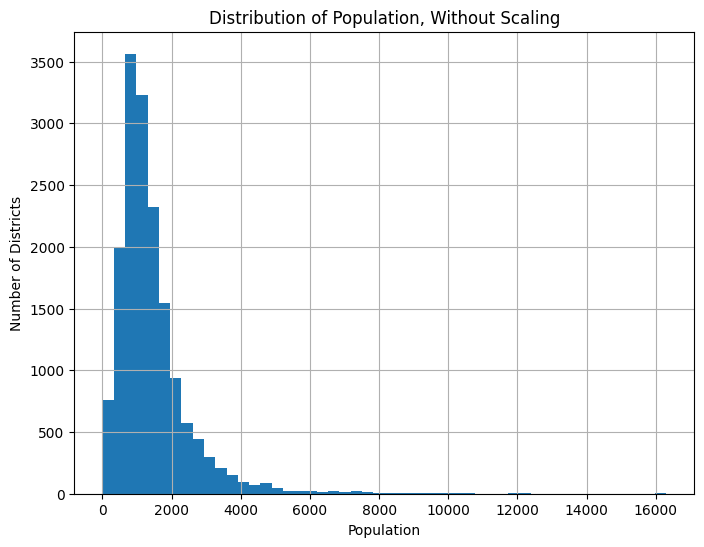

In [272]:
housing_num['population'].hist(bins=50,figsize=(8,6))
plt.title("Distribution of Population, Without Scaling")
plt.xlabel("Population")
plt.ylabel("Number of Districts")
plt.show()

## Feature Scaling:
1. ML algos dont perform well when the input numerical attributes have very different scales.
2. Without scaling, most models will be biased towards some feature and ignoring other features.

## Two Ways to get all attributes to have the same scale are:
1. Min-Max Scaling
2. Standardization

## Min-Max Scaling (Normalization):
1. For each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1.
2. Process: Subtracting the min value and Dividing by the difference between min and the max.
3. Sklearn has a transformer for this, MinMaxScalar(), it has a feature_range hyperparameter, that let's us change the range, by default it is from 0 to 1. 
4. In the case of Neural networks, they work best with zero-mean outputs, so from -1 to 1 is preferable.

In [273]:
from sklearn.preprocessing import MinMaxScaler
minMax = MinMaxScaler(feature_range=(-1,1))

In [274]:
housing_num_minMax = minMax.fit_transform(housing_num)

In [275]:
housing_num_minMax = pd.DataFrame(housing_num_minMax,columns=housing_num.columns,index=housing_num.index)

In [276]:
housing_num_minMax

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-0.608519,0.117021,1.000000,-0.831171,-0.641166,-0.807018,-0.614336,-0.779479
14973,0.210953,-0.661702,0.529412,-0.900148,-0.886294,-0.918660,-0.867090,-0.229293
3785,-0.519270,0.236170,0.254902,-0.945012,-0.930424,-0.931419,-0.924585,-0.733369
14689,0.468560,-0.744681,-0.372549,-0.787782,-0.726204,-0.774015,-0.709166,-0.756983
20507,0.257606,-0.740426,0.372549,-0.778015,-0.610243,-0.765796,-0.562815,-0.582171
...,...,...,...,...,...,...,...,...
14207,0.206897,-0.721277,0.568627,-0.886312,-0.808021,-0.885290,-0.805115,-0.419236
13105,0.022312,-0.197872,-0.137255,-0.850298,-0.809631,-0.826279,-0.801755,-0.714018
19301,0.478702,-0.991489,-0.529412,-0.800702,-0.750684,-0.655134,-0.716632,-0.508738
19121,0.206897,-0.678723,0.411765,-0.807773,-0.719117,-0.788738,-0.687512,-0.497166


## Let's see the same data after MinMax scaling:

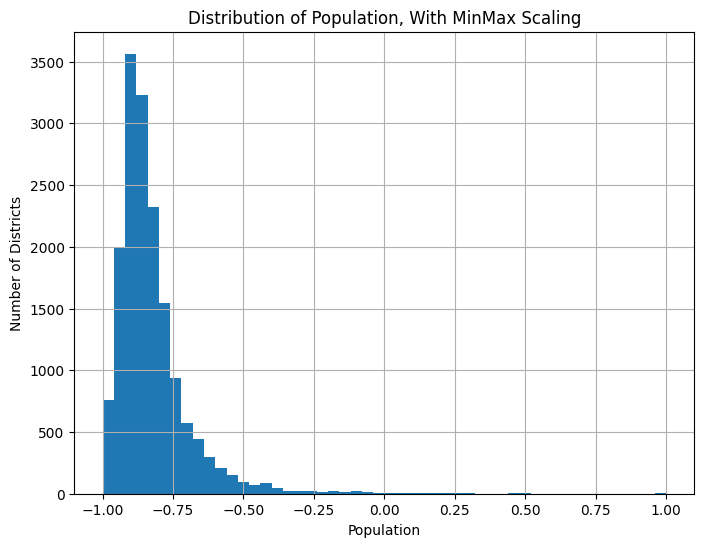

In [277]:
housing_num_minMax['population'].hist(bins=50,figsize=(8,6))
plt.title("Distribution of Population, With MinMax Scaling")
plt.xlabel("Population")
plt.ylabel("Number of Districts")
plt.show()

## Standarization:
1. Process: First subtract with mean(so standardized value have zero mean), then it divides the result by the standard deviation(so standardized values have a standard deviation of one).
2. It doesn't restrict values into a certain range, thus much less effected by outliers.
3. Sklearn provides a transformer called StandardScaler.

In [278]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()

In [279]:
housing_num_standardized = standardScaler.fit_transform(housing_num)

In [280]:
housing_num_standardized = pd.DataFrame(housing_num_standardized,columns=housing_num.columns,index=housing_num.index)

In [281]:
housing_num_standardized

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


## Let's see the same data with Standardized Scaled Values:

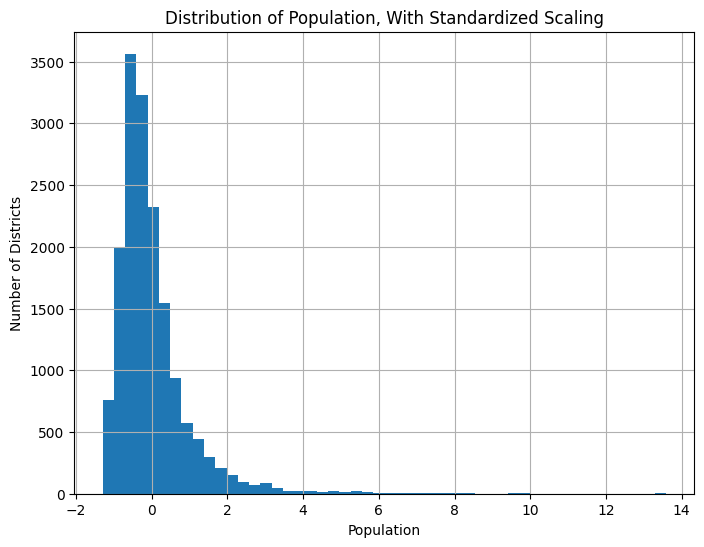

In [282]:
housing_num_standardized['population'].hist(bins=50,figsize=(8,6))
plt.title("Distribution of Population, With Standardized Scaling")
plt.xlabel("Population")
plt.ylabel("Number of Districts")
plt.show()

# Note:
1. When a feature's distribution has a heavy tail, like the one above. Both minMax and Standard scaling will squash most values into a small range.
2. ML models generally don't like this type of distribution.
3. Before we scale we should firstly shrink the heavy tail of the distribution, and if possible to make the distribution roughly symmetrical.

## Ways to make the heavy tail to symmetrical distribution:
1. Square Root: Raise the feature to a power between 0 and 1
2. If the feature has a really long and heavy tail, such as power law distribution. Then replacing the feature with it's logarithm might be good.
3. Bucketizing: Chopping the distribution into roughly equal-sized buckets, and replacing each feature value with the index of the bucket it belongs to, much like stratified sampling.


## Feature having MultiModal Distribution:
1. Bucketizing with some encoding.
2. Add a feature for each modes, representing the similarity between the main features and the particular node. The similarity measure is typically computed using a radial basis function(RBF).

### Radial Basis Function:
1. Any function that depends only on the distance between the input value and a fixed point.
2. In RBF, the hyperparameter gamma determines how quickly the similarity measure decays as x moves aways from a fixed point(constant).

### Using Sklearn's rbf_kernel() function:
When we create a new Gaussian rbf feature measuring the similarity between feautres and a fixed point.

In [283]:
from sklearn.metrics.pairwise import rbf_kernel
age_similar_35 = rbf_kernel(housing[['housing_median_age']],[[35]],gamma=0.1)

# Inverse Transformation Methods:
When we transforms the input and train the model with them the output will be the transformed version of the orginial, so get the orginial output as our desired answer, we perform the inverse_transform() method.

## Example for Transforming, Testing and Inverse Transforming:

In [ ]:
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame()) # Pandas Serise to Dataframe, as StandardScaler expects 2D inputs.

In [ ]:
# Training the Model with single raw input feature -> Median Income to predict Median House Value:
model = LinearRegression()
model.fit(housing[['median_income']],scaled_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [286]:
# Prepare Some New Data for testing:
some_new_data = housing[['median_income']].iloc[:5]
some_new_data

,median_income
13096,2.0987
14973,6.0876
3785,2.4330
14689,2.2618
20507,3.5292


In [ ]:
# Prediction:
scaled_prediction = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_prediction)
print("Scaled Prediction(Without Inverse Transformed Output): \n",scaled_prediction)
print("\n")
print("Desired Prediction(With Inverse Transformed Output): \n",predictions)

Scaled Prediction(Without Inverse Transformed Output): 
 [[-0.64466228]
 [ 0.80674175]
 [-0.52302364]
 [-0.5853166 ]
 [-0.12415952]]


Desired Prediction(With Inverse Transformed Output): 
 [[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


# Transformed Target Regressor:
1. The above process works fine, but a simpler option is to use a TransformedTragetRegressor. We just need to construct it, giving it the regression model and the label transformer, then fit it on the training set, using the orginial unscaled label.
2. It uses the transformer to scale the label and train the regression model on the resulting scaled labels.
3. When we want to predict the new data's output, it wil call the regression model's predict method and use the scalers's inverse_transform() method to produce the prediction.

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=StandardScaler()
)

model.fit(housing[['median_income']],housing_labels)

,regressor,LinearRegression()
,transformer,StandardScaler()
,func,None
,inverse_func,None
,check_inverse,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False
,copy,True


In [298]:
predictions = model.predict(some_new_data)
print("TransformedTargetRegressor Prediction: \n",predictions)

TransformedTargetRegressor Prediction: 
 [131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]
